# Import libraries

In [40]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import matplotlib.pyplot as plt
from matplotlib import rc
import functools
import itertools
from scipy.stats import wilcoxon

# Load data

In [41]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features_val.csv"), index_col=[0, 1])
X.head()

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
P65      SAMEA104062441       0.00000                      0.00000   
         SAMEA104062442       0.00000                      0.00000   
         SAMEA104062443       0.00000                      0.00000   
         SAMEA104062444       0.00000                      0.00000   
         SAMEA104062445       0.02755                      0.02755   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
P65      SAMEA104062441                                           0.00000   
         SAMEA104062442                                           0.00000   
         SAMEA104062443                                           0.00000   
         SAMEA104062444                                           0.00000   
         SAMEA104062445                                           0.02755   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
P65      SAMEA104062441                                              0.00000                      
         SAMEA104062442                                              0.00000                      
         SAMEA104062443                                              0.00000                      
         SAMEA104062444                                              0.00000                      
         SAMEA104062445                                              0.02755                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
P65      SAMEA104062441                                              0.00000                                             
         SAMEA104062442                                              0.00000                                             
         SAMEA104062443                                              0.00000                                             
         SAMEA104062444                                              0.00000                                             
         SAMEA104062445                                              0.02755                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
P65      SAMEA104062441                                             0.000000                                                                   
         SAMEA104062442                                             0.000000                                                                   
         SAMEA104062443                                             0.000000                                                                   
         SAMEA104062444                                             0.000000                                                                   
         SAMEA104062445                                             0.026885                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
P65      SAMEA104062441                                             0.000000              

In [42]:
meta = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata_val.csv"), index_col=[0, 1, 2])

# Compute GMHI2 and compare timepoints

In [43]:
gmhi2 = load(os.path.join(config.MODEL_DIR, "gmhi2_model.joblib"))
gmhi2

LogisticRegression(C=0.03, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [44]:
meta["GMHI2"] = gmhi2.decision_function(X > config.PRESENCE_CUTOFF)
meta

health_status/host_diet timepoint  \
Study_ID Sample Accession Subject_ID                                     
P65      SAMEA104062441   ERAS10                     Healthy        D0   
         SAMEA104062442   ERAS10                     Healthy      D180   
         SAMEA104062443   ERAS10                     Healthy       D42   
         SAMEA104062444   ERAS10                     Healthy        D8   
         SAMEA104062445   ERAS11                     Healthy        D0   
...                                                      ...       ...   
P90      SAMN16701308     9003                           EEN         3   
         SAMN16701460     9017                         Vegan         1   
         SAMN16701459     9016                           EEN        15   
         SAMN16701458     9016                           EEN        14   
         SAMN16701457     9016                           EEN        13   

                                         GMHI2  
Study_ID Sample Accession Subject_ID            
P65      SAMEA104062441   ERAS10      2.365224  
         SAMEA104062442   ERAS10     -1.553617  
         SAMEA104062443   ERAS10     -0.650648  
         SAMEA104062444   ERAS10     -0.938069  
         SAMEA104062445   ERAS11      2.574110  
...                                        ...  
P90      SAMN16701308     9003       -0.768061  
         SAMN16701460     9017        0.957266  
         SAMN16701459     9016       -0.320137  
         SAMN16701458     9016       -0.828472  
         SAMN16701457     9016       -0.365251  

[1297 rows x 3 columns]

In [45]:
studies = np.unique(X.index.get_level_values(0))

In [46]:
def test_significance(meta_df):
    for phenotype in np.unique(meta_df["health_status/host_diet"]):
        print(phenotype)
        
        curr_df = meta_df[meta_df["health_status/host_diet"] == phenotype]
        
        timepoints = list(curr_df["timepoint"].unique())
        
        if np.nan in timepoints:
            timepoints.remove(np.nan)
        
        meta_timepoints = dict([(time, curr_df[curr_df["timepoint"] == time]) for time in timepoints])
        subjects_in_all_timepoints = list(functools.reduce(lambda a, b : a & b, [set(meta_timepoints[t].index) for t in timepoints]))
        meta_timepoints = dict([(time, meta_timepoints[time].loc[subjects_in_all_timepoints]) for time in timepoints])
        for comb in itertools.combinations(timepoints, 2):
            print(comb)
            print(wilcoxon(meta_timepoints[comb[0]]["GMHI2"], meta_timepoints[comb[1]]["GMHI2"]))
            print((meta_timepoints[comb[1]]["GMHI2"] - meta_timepoints[comb[0]]["GMHI2"]).mean())
            print()

In [47]:
for study in studies[:-1]:
    curr_meta = meta.loc[study]
    curr_meta.index = curr_meta.index.get_level_values(1)
    
    if study == "P106":
        curr_meta = curr_meta[curr_meta["health_status/host_diet"] != "Healthy"]
    if study == "P116":
        curr_meta["health_status/host_diet"] = "Cancer"
        
    print(study)
    test_significance(curr_meta)
    print()
    print()
    print()
    print()

P106
Irritable bowel syndrome (IBS)
('0', '12')
WilcoxonResult(statistic=98.0, pvalue=0.3705310821533203)
0.22641482873258453

('0', '6')
WilcoxonResult(statistic=102.0, pvalue=0.4434065818786621)
0.17984997254324686

('12', '6')
WilcoxonResult(statistic=123.0, pvalue=0.9239659309387207)
-0.04656485618933775





P107
CONTROL DIET
('8 weeks', 'baseline')
WilcoxonResult(statistic=341.0, pvalue=0.6687842626114034)
-0.10080927922009857

('8 weeks', '4 weeks')
WilcoxonResult(statistic=267.0, pvalue=0.13335930358436532)
-0.17458786341730703

('baseline', '4 weeks')
WilcoxonResult(statistic=341.0, pvalue=0.6687842626114034)
-0.0737785841972085

MED DIET
('baseline', '8 weeks')
WilcoxonResult(statistic=384.0, pvalue=0.3986709137770713)
0.09274932071935775

('baseline', '4 weeks')
WilcoxonResult(statistic=366.0, pvalue=0.4032594687026425)
0.03236073540714943

('8 weeks', '4 weeks')
WilcoxonResult(statistic=443.0, pvalue=0.915359293647618)
-0.06038858531220829





P116
Cancer
('1', '2')
Wilcox

/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
# deal with p90
study = "P90"
curr_meta = meta.loc[study]
curr_meta.index = curr_meta.index.get_level_values(1)
curr_meta

,health_status/host_diet,timepoint,GMHI2
Subject_ID,,,
9016,EEN,12,-0.474825
9016,EEN,11,-0.315008
9016,EEN,7,-1.242795
9003,EEN,2,0.368156
9016,EEN,6,-0.930921
...,...,...,...
9003,EEN,3,-0.768061
9017,Vegan,1,0.957266
9016,EEN,15,-0.320137


EEN


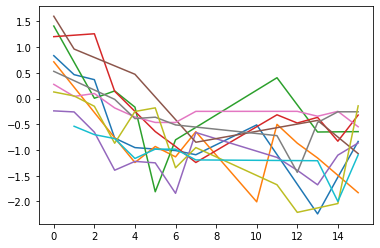

Omnivore


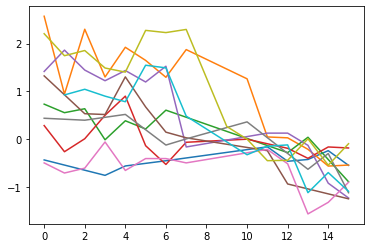

Vegan


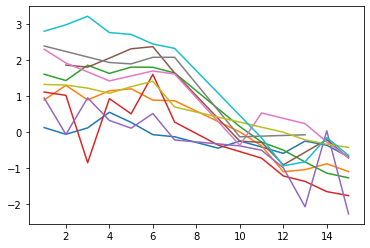

In [67]:
for phenotype in np.unique(curr_meta["health_status/host_diet"]):
    print(phenotype)

    curr_df = curr_meta[curr_meta["health_status/host_diet"] == phenotype]
    for subject in np.unique(curr_df.index):
        df = curr_df.loc[subject]
        df = df[df["timepoint"] != "PS"]
        df["timepoint"] = df["timepoint"].astype(int)
        df = df.sort_values("timepoint")
        plt.plot(df["timepoint"], df["GMHI2"])
    plt.show()